 # Setup Paths

In [1]:
import os

In [2]:
#Download tf object detection model using transfer learning
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [3]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [7]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# TF Pretrained Models and Installation of TFOD

In [6]:
# https://www.tensorflow.org/install/source_windows

In [6]:
if os.name=='nt':
    !pip install wget
    import wget

In [7]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

In [ ]:
!pip list

In [ ]:
%pip uninstall opencv-python-headless

In [ ]:
!pip uninstall protobuf matplotlib -y
!pip install protobuf matplotlib==3.2

In [6]:
import object_detection

In [5]:
!pip list

Package                       Version     Editable project location
----------------------------- ----------- ---------------------------------------
absl-py                       1.4.0
apache-beam                   2.46.0
asttokens                     2.2.1
astunparse                    1.6.3
avro-python3                  1.10.2
backcall                      0.2.0
cachetools                    5.3.0
certifi                       2022.12.7
charset-normalizer            3.1.0
click                         8.1.3
cloudpickle                   2.2.1
colorama                      0.4.6
comm                          0.1.2
contextlib2                   21.6.0
contourpy                     1.0.7
crcmod                        1.7
cycler                        0.11.0
Cython                        0.29.33
debugpy                       1.6.6
decorator                     5.1.1
dill                          0.3.1.1
dm-tree                       0.1.8
docopt                        0.6.2
easyocr     

In [ ]:
#Download model
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

# Create Label Map

In [6]:
labels = [{'name':'licence', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# Creating TF records

In [8]:
# OPTIONAL IF RUNNING ON COLAB
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

In [9]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [10]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

Successfully created the TFRecord file: Tensorflow\workspace\annotations\train.record
^C


Successfully created the TFRecord file: Tensorflow\workspace\annotations\test.record


# Copying Model Config to Training Folder

In [14]:
#Copy pipeline config file to the model
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

        1 file(s) copied.


# Updating Config For Transfer Learning

In [7]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [8]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG']) 

In [ ]:
config

In [9]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [10]:
#Fine tuning
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [11]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# Training the model

In [20]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [21]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=10000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [22]:
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --num_train_steps=10000


In [ ]:
!{command}

# Loading Model From Checkpoint

In [12]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [13]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [ ]:
# !pip install opencv-python


# Detection from Image

In [32]:
import cv2
import numpy as np
import matplotlib
matplotlib.use("Tkagg")
from matplotlib import pyplot as plt
%matplotlib inline

In [33]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [34]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'test2.jpg')

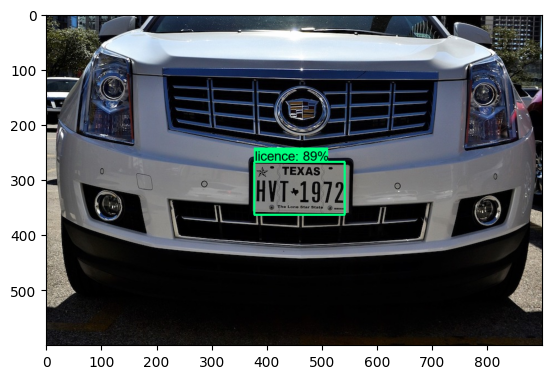

In [35]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# Installing and using EasyOCR


In [ ]:
!pip install easyocr

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

In [36]:
import easyocr

In [37]:
detection_threshold = 0.7

In [24]:
scores

[0.88718396]

In [38]:
image = image_np_with_detections
scores = list(filter(lambda x: x> detection_threshold, detections["detection_scores"]))
boxes = detections["detection_boxes"][:len(scores)]
classes = detections["detection_classes"][:len(scores)]

In [21]:
detections["detection_scores"] > detection_threshold

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [39]:
#Get width and height of image
width = image.shape[1]
height = image.shape[0]

In [20]:
height

600

[([[48, 4], [124, 4], [124, 28], [48, 28]], 'TEXAS', 0.9995418774671965), ([[0, 24], [165, 24], [165, 86], [0, 86]], 'HVI-1972', 0.900690852589191), ([[44, 78], [126, 78], [126, 84], [44, 84]], 'Thurlmnnte e ennennn', 7.679169996111632e-05)]


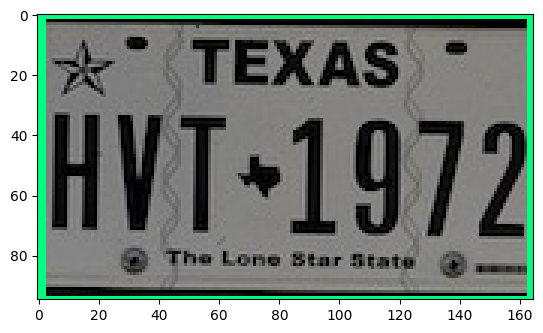

In [40]:
#Applying ROI(Region of Interest) Filtering and OCR
for idx,box in enumerate(boxes):
    roi = box * [height, width, height, width]
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])] #Filtering through the numpy array
    reader = easyocr.Reader(["en"]) #read english language
    ocr_res = reader.readtext(region)
    print(ocr_res)
    #We convert the BGR model to RGB for any color variation
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))

In [42]:
for result in ocr_res:
    print(np.sum(np.subtract(result[0][2],result[0][1])))
    print(result[1])

24
TEXAS
62
HVI-1972
6
Thurlmnnte e ennennn


# OCR Filtering for main region

In [41]:
region_threshold = 0.5

In [42]:
def filter_text(region, ocr_res, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]

    plate = []

    for result in ocr_res:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        width = np.sum(np.subtract(result[0][2], result[0][1]))

        if length*width / rectangle_size > region_threshold:
            plate.append(result[1])
        print(length, width)
    return plate

In [43]:
filter_text(region, ocr_res, region_threshold)

76 24
165 62
82 6


['HVI-1972']

# Put Together

In [44]:
region_threshold = 0.6

In [45]:
def ocr_it(image, detections, detection_threshold, region_threshold):
    
    #Scores boxes and classes above the treshold
    scores = list(filter(lambda x: x> detection_threshold, detections["detection_scores"]))
    boxes = detections["detection_boxes"][:len(scores)]
    classes = detections["detection_classes"][:len(scores)]

    #Image dimentons
    width = image.shape[1]
    height = image.shape[0]

    #Applying ROI(Region of Interest) Filtering and OCR
    for idx,box in enumerate(boxes):
        roi = box * [height, width, height, width]
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])] #Filtering through the numpy array
        reader = easyocr.Reader(["en"]) #read english language
        ocr_res = reader.readtext(region)

        text = filter_text(region, ocr_res, region_threshold)
        plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        # print(ocr_res)
        #We convert the BGR model to RGB for any color variation
        plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        print(text)
    return text, region

76 24
165 62
82 6
['HVI-1972']


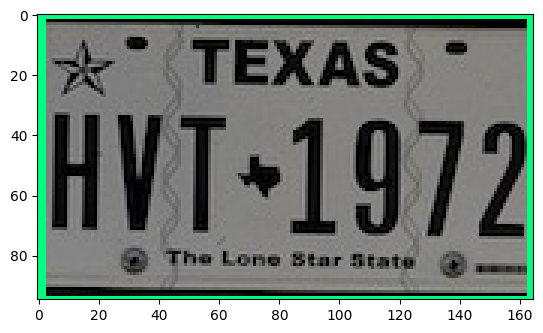

In [46]:
text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)

# Saving the results in CSV

In [47]:
import csv 
import uuid 

In [49]:
def save_results(text, region, csv_filename, folder_path):
    img_name = "{}.jpg".format(uuid.uuid1())

    cv2.imwrite(os.path.join(folder_path, img_name),region)

    with open(csv_filename, mode="a", newline="") as f:
        csv_writer = csv.writer(f, delimiter=",", quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow([img_name, text])

In [51]:
save_results(text, region, "detection_results.csv","Detection_images")

# Real Time Detections and Saving Results


351 127
['ABL-1234']


222 51
374 138
196 38
[]


272 56
393 195
261 69
['0-1234']


297 58
435 182
269 69
[]
264 50
468 160
255 53
[]


281 45
428 164
249 63
['ABC+1234']
261 52
431 175
253 66
['IBC-1234']


275 67
449 193
267 76
['IBC-1234']


266 58
474 188
257 72
['ABC-1234']


247 49
409 163
241 66
['IBC-1234']
258 51
437 172
245 61
['ABC-1234']


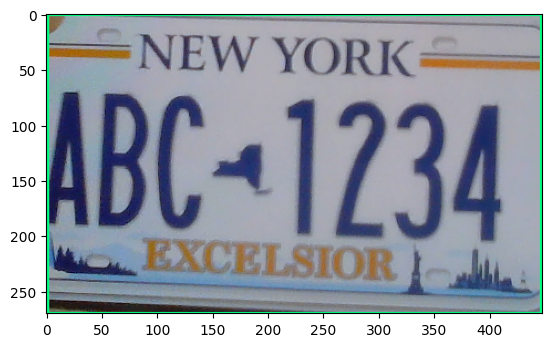

In [52]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)
    
    #Getting the license plate in real time
    try:
        text, region = ocr_it(image_np_with_detections,detections, detection_threshold, region_threshold)
        save_results(text, region, "realtimeresults.csv", "Detection_images")
    except:
        pass

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break